<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Business Analytics e Machine Learning Para Projetos de Data Science</font>
## <font color='blue'>Projeto 10</font>
### <font color='blue'>Previsão de Demanda Para Otimizar a Entrega de Produtos e Uso de Transportadoras</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

O procedimento de instalação de pacotes e dependências está no arquivo LEIAME.txt

In [2]:
#!pip install -q tensorflow

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Imports
import sklearn
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Definir a semente para garantir reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [6]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando os Dados e Definindo a Série Temporal

In [4]:
# Carrega os dados
df_dsa = pd.read_csv('dataset.csv')

In [5]:
# Shape
df_dsa.shape

(55, 5)

In [6]:
# Amostra
df_dsa.head()

,ano,otif,lead_time,custo_transporte,indice_rotatividade_estoque
0,1970,11.43,5.63,1980.10,0.15
1,1971,14.59,7.34,1930.63,0.39
2,1972,12.45,6.58,1057.70,2.46
3,1973,11.35,14.45,2881.87,0.73
4,1974,9.05,8.05,1617.81,1.48


In [7]:
# Amostra
df_dsa.tail()

,ano,otif,lead_time,custo_transporte,indice_rotatividade_estoque
50,2020,11.83,19.40,2518.30,1.69
51,2021,9.33,7.98,1922.75,1.70
52,2022,19.78,13.22,1517.96,1.72
53,2023,18.78,14.22,1617.96,1.73
54,2024,17.48,19.32,1717.96,1.79


Veja as definições nos ebooks do Capítulo 18 do curso.

In [8]:
# Define nossa série temporal
indice_rotatividade_estoque = df_dsa['indice_rotatividade_estoque'].values.reshape(-1, 1)

In [9]:
indice_rotatividade_estoque

array([[ 0.15],
       [ 0.39],
       [ 2.46],
       [ 0.73],
       [ 1.48],
       [ 1.12],
       [ 0.41],
       [ 0.48],
       [ 1.15],
       [ 0.31],
       [ 0.58],
       [ 0.23],
       [ 0.57],
       [ 2.79],
       [ 0.43],
       [ 2.9 ],
       [-0.2 ],
       [ 1.8 ],
       [ 0.  ],
       [ 0.3 ],
       [ 1.72],
       [ 1.1 ],
       [ 2.26],
       [ 0.86],
       [ 2.6 ],
       [-0.17],
       [-0.49],
       [ 2.6 ],
       [ 0.38],
       [-1.  ],
       [ 2.19],
       [ 1.84],
       [ 0.33],
       [-0.38],
       [-2.4 ],
       [ 2.16],
       [ 2.77],
       [-2.45],
       [ 0.82],
       [ 0.64],
       [ 1.3 ],
       [ 0.34],
       [ 0.93],
       [ 0.53],
       [ 0.85],
       [ 0.5 ],
       [ 0.66],
       [ 0.98],
       [ 0.97],
       [ 1.63],
       [ 1.69],
       [ 1.7 ],
       [ 1.72],
       [ 1.73],
       [ 1.79]])

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Função Para Preparar o Dataset Para Treinamento do Modelo

In [13]:
# Função para criar o dataset para o modelo LSTM com look_back
# O parâmetro look_back define o número de passos no tempo que o modelo usará para fazer cada previsão
def dsa_prepara_dados(data, look_back = 1):

    # Inicializa duas listas vazias, X e Y, que conterão as sequências de entrada e saída, respectivamente
    X, Y = [], []
    
    # Itera pelo conjunto de dados menos o valor de look_back. 
    # Isso é feito para evitar índices fora dos limites do array
    for i in range(len(data) - look_back):
        
        # Coleta uma sequência de dados de tamanho look_back começando no índice i
        a = data[i:(i + look_back), 0]
        
        # Adiciona a sequência à lista X
        X.append(a)
        
        # Adiciona o valor imediatamente após a sequência de look_back à lista Y. 
        # Esse será nosso valor de saída (target).
        Y.append(data[i + look_back, 0])
    
    # Converte X e Y para arrays numpy para compatibilidade com a maioria das bibliotecas de aprendizado de máquina
    return np.array(X), np.array(Y)

## Dividindo a Série Temporal em Treino e Teste

In [14]:
# Dividimos os dados em treinamento e teste (respeitando a ordem cronológica dos dados)
indice = int(len(indice_rotatividade_estoque) * 0.8)
dados_treino, dados_teste = indice_rotatividade_estoque[0:indice, :], indice_rotatividade_estoque[indice:len(indice_rotatividade_estoque), :]

In [15]:
dados_treino

array([[ 0.15],
       [ 0.39],
       [ 2.46],
       [ 0.73],
       [ 1.48],
       [ 1.12],
       [ 0.41],
       [ 0.48],
       [ 1.15],
       [ 0.31],
       [ 0.58],
       [ 0.23],
       [ 0.57],
       [ 2.79],
       [ 0.43],
       [ 2.9 ],
       [-0.2 ],
       [ 1.8 ],
       [ 0.  ],
       [ 0.3 ],
       [ 1.72],
       [ 1.1 ],
       [ 2.26],
       [ 0.86],
       [ 2.6 ],
       [-0.17],
       [-0.49],
       [ 2.6 ],
       [ 0.38],
       [-1.  ],
       [ 2.19],
       [ 1.84],
       [ 0.33],
       [-0.38],
       [-2.4 ],
       [ 2.16],
       [ 2.77],
       [-2.45],
       [ 0.82],
       [ 0.64],
       [ 1.3 ],
       [ 0.34],
       [ 0.93],
       [ 0.53]])

In [16]:
dados_teste

array([[0.85],
       [0.5 ],
       [0.66],
       [0.98],
       [0.97],
       [1.63],
       [1.69],
       [1.7 ],
       [1.72],
       [1.73],
       [1.79]])

## Padronização dos Dados

In [17]:
# Normaliza os dados (requerimento para redes neurais)
scaler = MinMaxScaler(feature_range = (0, 1))

In [18]:
# Treina e aplica o scaler em treino
# Somente aplica em teste
dados_treino_norm = scaler.fit_transform(dados_treino)
dados_teste_norm = scaler.transform(dados_teste)

## Preparação e Ajuste do Formato dos Dados

In [19]:
# Criamos os datasets para o modelo LSTM
look_back = 1
X_treino, y_treino = dsa_prepara_dados(dados_treino_norm, look_back)
X_teste, y_teste = dsa_prepara_dados(dados_teste_norm, look_back)

In [20]:
# Reshape dos dados para [samples, time steps, features]. Isso é um requerimento do modelo LSTM
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

## Arquitetura do Modelo de Machine Learning

Veja a descrição da arquitetura no videobook do Capítulo 18 do curso.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/

In [21]:
# Construindo o modelo LSTM
# passada pra frente, definição da arquitetura do modelo
modelo = tf.keras.models.Sequential([tf.keras.layers.LSTM(50, input_shape = (look_back, 1)),
                                     tf.keras.layers.Dense(1)])

## Compilação do Modelo

Veja a descrição da compilação no videobook do Capítulo 18 do curso.

In [22]:
# Compila o modelo
# passada pra trás, aqui é onde acontece realmente o aprendizado de máquina
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## Treinamento e Avaliação do Modelo

In [24]:

%time
# Treinamento do modelo
modelo.fit(
    X_treino, 
    y_treino, 
    epochs = 50, #número de vezes que o modelo verá todo o conjunto de dados de treinamento
    batch_size = 1, #define quantas amostras serão usadas, afeta na memória do computador e na velocidade de treinamento
    verbose = 1
)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 7.15 μs
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - loss: 0.3223 
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.1435
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.0736
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0674
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0671
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0660
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.0649
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0638
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0627
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0617
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0608
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 0.0599
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0591
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss:

In [25]:
# Fazendo previsões com o modelo
previsao_treino = modelo.predict(X_treino)
previsao_teste = modelo.predict(X_teste)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [26]:
# Transformar de volta para a escala original para calcular o erro
previsao_treino = scaler.inverse_transform(previsao_treino)
y_treino_rescaled = scaler.inverse_transform([y_treino])
previsao_teste = scaler.inverse_transform(previsao_teste)
y_teste_rescaled = scaler.inverse_transform([y_teste])

In [27]:
# Calcular o RMSE
train_score = np.sqrt(mean_squared_error(y_treino_rescaled[0], previsao_treino[:, 0]))
print(f"\nRMSE em Treino: {train_score:.2f}")


RMSE em Treino: 1.18


In [28]:
test_score = np.sqrt(mean_squared_error(y_teste_rescaled[0], previsao_teste[:, 0]))
print(f"RMSE em Teste: {test_score:.2f}")

RMSE em Teste: 0.76


## Formatando os Dados Para Visualização

In [29]:
# Cria um índice para os dados de treino originais, começando em 'look_back' 
# e terminando em 'look_back + len(y_treino_rescaled[0])'.
# Este índice será utilizado para associar cada ponto de dado de treino ao seu ano correspondente 
# no DataFrame 'df_dsa'.
original_train_data_index = df_dsa['ano'][look_back:look_back + len(y_treino_rescaled[0])]

In [30]:
# Cria um índice para os dados de teste originais.
# Começa a partir do final dos dados de treino padronizados e vai até o final dos dados de teste padronizados.
# O '2 * look_back' é utilizado para ajustar o índice corretamente.
original_test_data_index = df_dsa['ano'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back + len(y_teste_rescaled[0])]

In [31]:
# Cria um índice para os valores previstos em treino, começando em 'look_back' 
# e terminando em 'look_back + len(previsao_treino)'.
# Este índice será utilizado para associar cada ponto previsto no conjunto de treino ao seu ano correspondente 
# no DataFrame 'df_dsa'.
predicted_train_data_index = df_dsa['ano'][look_back:look_back + len(previsao_treino)]

In [32]:
# Cria um índice para os valores previstos em teste.
predicted_test_data_index = df_dsa['ano'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back+len(previsao_teste)]

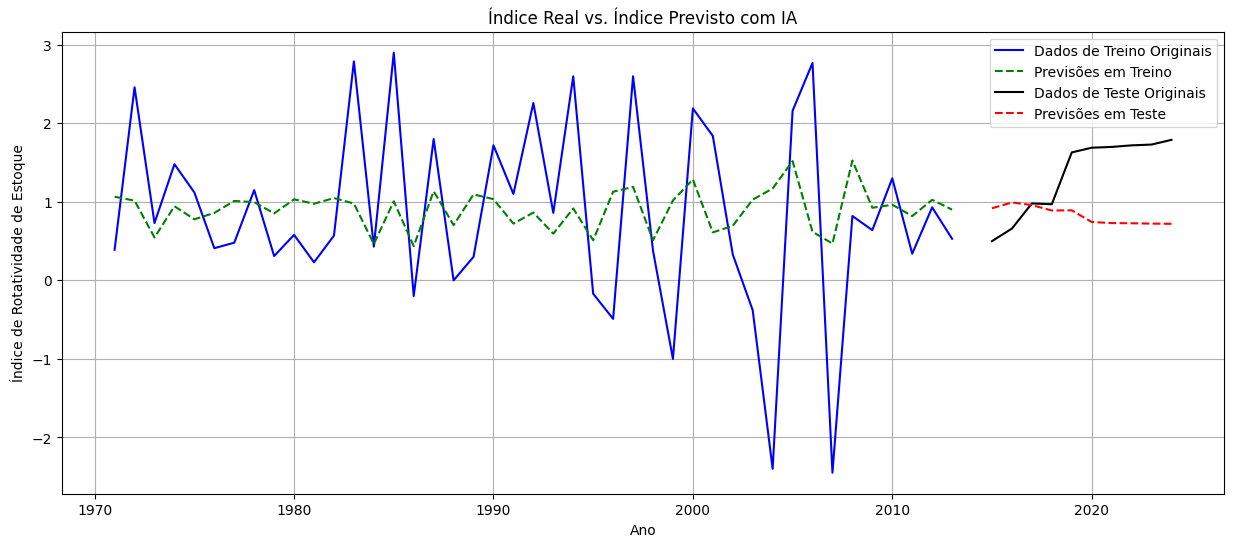

In [33]:
# Plotar os resultados
plt.figure(figsize = (15, 6))
plt.plot(original_train_data_index, 
         y_treino_rescaled[0], 
         label = "Dados de Treino Originais", 
         color = "blue", 
         linestyle = '-')
plt.plot(predicted_train_data_index, 
         previsao_treino[:, 0], 
         label = "Previsões em Treino", 
         color = "green", linestyle='--')
plt.plot(original_test_data_index, 
         y_teste_rescaled[0], 
         label = "Dados de Teste Originais", 
         color = "black", 
         linestyle = '-')
plt.plot(predicted_test_data_index, 
         previsao_teste[:, 0], 
         label = "Previsões em Teste", 
         color = "red", 
         linestyle = '--')
plt.title("Índice Real vs. Índice Previsto com IA")
plt.xlabel("Ano")
plt.ylabel("Índice de Rotatividade de Estoque")
plt.legend()
plt.grid(True)
plt.show()

## Módulo de Forecast Para Previsões com o Modelo Treinado

In [34]:
# Usamos a última entrada da série original de teste para fazer a próxima previsão
last_data = dados_teste_norm[-look_back:]
last_data = np.reshape(last_data, (1, look_back, 1))

In [35]:
# Lista
lista_previsoes = []

In [36]:
# Loop de Previsão para prever 2 anos (2025 e 2026)
for _ in range(2):  

    # Previsão com o modelo (usamos os dados normalizados)
    prediction = modelo.predict(last_data)

    # Adiciona a previsão à lista de previsões
    lista_previsoes.append(prediction[0, 0])

    # Atualiza os dados para incluir a nova previsão e remover o valor mais antigo
    # Isso significa que usaremos a previsão de 2025 para prever o valor de 2026
    last_data = np.roll(last_data, shift = -1)
    last_data[0, look_back - 1, 0] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [37]:
# Transformar de volta para a escala original
lista_previsoes_rescaled = scaler.inverse_transform(np.array(lista_previsoes).reshape(-1, 1))

In [38]:
print(f"\nPrevisão do Índice de Rotatividade de Estoque Para 2025: {lista_previsoes_rescaled[0, 0]:.2f}")
print(f"Previsão do Índice de Rotatividade de Estoque Para 2026: {lista_previsoes_rescaled[1, 0]:.2f}")


Previsão do Índice de Rotatividade de Estoque Para 2025: 0.71
Previsão do Índice de Rotatividade de Estoque Para 2026: 0.95


In [39]:
%watermark -a "Data Science Academy"

UsageError: Line magic function `%watermark` not found.


In [40]:
#%watermark -v -m

In [41]:
#%watermark --iversions

# Fim